


6_model_building_tuning_F3
-------------------
Group , October 19, 2022
1. Eduardo Garcia
2. Nari Kim
3. Thi Anh Ba Dang
4. Vishnu Prabhakar
5. VS Chaitanya Madduri
6. Yumeng Zhang


> <i>Description: We are trying to predict the retruns for 2 hours window.</i>


- We are builing a basic model using the columns and the target provided in the intial dataset.

- Used Feature Set 3 which are basic features the data has.

### Pre requisites: 
1. And add the shortcut of the drive link : https://drive.google.com/drive/folders/1F8P3UlqSE6lFpHyBidVArdsXJLenKi3O?usp=share_link to your personal drive.


Files:
crypto_data_hour_cleaned_v2.csv - Hourly Data

### Output files:

Files:




## Load and transform data

In [ ]:
# Connecting to the google drive
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import clear_output

Mounted at /content/drive


In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.model_selection import RandomizedSearchCV

#picking models for prediction.
from sklearn.svm import SVC

In [ ]:
# file path
folder_path = '/content/drive/MyDrive/MADS_23_DL_final_project'
hour = pd.read_csv(folder_path + '/data/crypto_data_hour_cleaned_v2.csv')

In [ ]:
hour.head()

,Open Time,Open,High,Low,Close,Volume,train_test,Crypto,pct_change_1hour,pct_change_2hour,pct_change_1day
0,2013-04-01 00:00:00,93.155,93.155,93.155,93.155,12.250,Train,BTC,NaN,NaN,NaN
1,2013-04-01 01:00:00,93.700,93.790,93.700,93.790,54.120,Train,BTC,0.006817,NaN,NaN
2,2013-04-01 02:00:00,94.068,94.480,94.000,94.000,205.800,Train,BTC,0.002239,0.009071,NaN
3,2013-04-01 04:00:00,93.550,94.000,93.550,94.000,9.328,Train,BTC,0.000000,0.002239,NaN
4,2013-04-01 05:00:00,94.230,94.230,94.230,94.230,4.826,Train,BTC,0.002447,0.002447,NaN


In [ ]:
# drop columns
col_to_drop = ['pct_change_1hour','pct_change_1day']
only_2hour = hour[hour.columns.difference(col_to_drop)]

In [ ]:
only_2hour.head()

,Close,Crypto,High,Low,Open,Open Time,Volume,pct_change_2hour,train_test
0,93.155,BTC,93.155,93.155,93.155,2013-04-01 00:00:00,12.250,NaN,Train
1,93.790,BTC,93.790,93.700,93.700,2013-04-01 01:00:00,54.120,NaN,Train
2,94.000,BTC,94.480,94.000,94.068,2013-04-01 02:00:00,205.800,0.009071,Train
3,94.000,BTC,94.000,93.550,93.550,2013-04-01 04:00:00,9.328,0.002239,Train
4,94.230,BTC,94.230,94.230,94.230,2013-04-01 05:00:00,4.826,0.002447,Train


## Generate Feature Engineering

### Extract year, month, day, hour and weekday from time stamp

### Encoding of ordinals

In [ ]:

def encode_cyclicals(df_x):
  '''
  The function converts the date features encoded in the Sine and cosines.
  Input : 
  df_x : Input data frame to be processed
  Output :
  df_x : processed dataframe.
  '''
    #"month","day","hour", "minute", "dayofweek"
    
    

    df_x['month_sin'] = np.sin(2*np.pi*df_x.month/12)
    df_x['month_cos'] = np.cos(2*np.pi*df_x.month/12)
    df_x.drop('month', axis=1, inplace=True)
    
    df_x['day_sin'] = np.sin(2*np.pi*df_x.day/31)
    df_x['day_cos'] = np.cos(2*np.pi*df_x.day/31)
    df_x.drop('day', axis=1, inplace=True)

    df_x['dayofweek_sin'] = np.sin(2*np.pi*df_x.weekday/7)
    df_x['dayofweek_cos'] = np.cos(2*np.pi*df_x.weekday/7)
    df_x.drop('weekday', axis=1, inplace=True)
    
    df_x['hour_sin'] = np.sin(2*np.pi*df_x.hour/24)
    df_x['hour_cos'] = np.cos(2*np.pi*df_x.hour/24)
    df_x.drop('hour', axis=1, inplace=True)

    df_x['hour_sin'] = np.sin(2*np.pi*df_x.minute/60)
    df_x['hour_cos'] = np.cos(2*np.pi*df_x.minute/60)
    df_x.drop('minute', axis=1, inplace=True)
    
   
    
    return df_x

In [ ]:
# Extracting the Date details
df = only_2hour.copy()
df['year'] = pd.DatetimeIndex(df['Open Time']).year
df['month'] = pd.DatetimeIndex(df['Open Time']).month
df['day'] = pd.DatetimeIndex(df['Open Time']).day
df['weekday'] = pd.DatetimeIndex(df['Open Time']).dayofweek


df['Open Time'] = pd.to_datetime(df['Open Time'])
df['minute'] = df['Open Time'].dt.minute
df['hour'] = df['Open Time'].dt.hour


In [ ]:
df.head(2)

,Close,Crypto,High,Low,Open,Open Time,Volume,pct_change_2hour,train_test,year,month,day,weekday,minute,hour
0,93.155,BTC,93.155,93.155,93.155,2013-04-01 00:00:00,12.25,NaN,Train,2013,4,1,0,0,0
1,93.790,BTC,93.790,93.700,93.700,2013-04-01 01:00:00,54.12,NaN,Train,2013,4,1,0,0,1


In [ ]:
# Transform the date details
df_v2 = encode_cyclicals(df.copy())

In [ ]:
df = df_v2.copy()

### One hot coding the coins

By this process we are tagging which record belongs which coin

In [ ]:
# Applying one hot encoding on Crypto Coin 

y_dummies = pd.get_dummies(df['Crypto'], prefix='Crypto', drop_first= False)
df_v2 = pd.concat([df, y_dummies], axis=1)


In [ ]:
df_v2.head()

,Close,Crypto,High,Low,Open,Open Time,Volume,pct_change_2hour,train_test,year,...,Crypto_ADA,Crypto_BTC,Crypto_ETC,Crypto_ETH,Crypto_LINK,Crypto_LTC,Crypto_TRX,Crypto_XLM,Crypto_XMR,Crypto_XRP
0,93.155,BTC,93.155,93.155,93.155,2013-04-01 00:00:00,12.250,NaN,Train,2013,...,0,1,0,0,0,0,0,0,0,0
1,93.790,BTC,93.790,93.700,93.700,2013-04-01 01:00:00,54.120,NaN,Train,2013,...,0,1,0,0,0,0,0,0,0,0
2,94.000,BTC,94.480,94.000,94.068,2013-04-01 02:00:00,205.800,0.009071,Train,2013,...,0,1,0,0,0,0,0,0,0,0
3,94.000,BTC,94.000,93.550,93.550,2013-04-01 04:00:00,9.328,0.002239,Train,2013,...,0,1,0,0,0,0,0,0,0,0
4,94.230,BTC,94.230,94.230,94.230,2013-04-01 05:00:00,4.826,0.002447,Train,2013,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
df=df_v2.copy()

NameError: ignored

In [ ]:
df.drop(['Crypto'], axis=1, inplace=True)

In [ ]:
# creating a additional column if the model is used for new coin.
df['other_crypto'] =0

In [ ]:
df.head()

,Close,High,Low,Open,Open Time,Volume,pct_change_2hour,train_test,year,month_sin,...,Crypto_BTC,Crypto_ETC,Crypto_ETH,Crypto_LINK,Crypto_LTC,Crypto_TRX,Crypto_XLM,Crypto_XMR,Crypto_XRP,other_crypto
0,93.155,93.155,93.155,93.155,2013-04-01 00:00:00,12.250,NaN,Train,2013,0.866025,...,1,0,0,0,0,0,0,0,0,0
1,93.790,93.790,93.700,93.700,2013-04-01 01:00:00,54.120,NaN,Train,2013,0.866025,...,1,0,0,0,0,0,0,0,0,0
2,94.000,94.480,94.000,94.068,2013-04-01 02:00:00,205.800,0.009071,Train,2013,0.866025,...,1,0,0,0,0,0,0,0,0,0
3,94.000,94.000,93.550,93.550,2013-04-01 04:00:00,9.328,0.002239,Train,2013,0.866025,...,1,0,0,0,0,0,0,0,0,0
4,94.230,94.230,94.230,94.230,2013-04-01 05:00:00,4.826,0.002447,Train,2013,0.866025,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
df['pct_change_2hour'].describe()

count    494730.000000
mean          0.001408
std           0.450256
min          -0.999995
25%          -0.006720
50%           0.000000
75%           0.007028
max         222.716582
Name: pct_change_2hour, dtype: float64

### Defining the Target Variable. 

We want to follow the classification approach and hence based on the "pct_change_2hour" we are creating 3 classes one class '0' when the returns are negative and '1' When the retruns are postive.

Finally, 2 when the returns beat the market value.

In [ ]:
market_RoR = 26.89
market_RoR_2h = market_RoR/(365*12)

In [ ]:
df['Target'] = np.where(df['pct_change_2hour']>0, 1,0)

df['Target'] = np.where(df['pct_change_2hour']>market_RoR_2h, 2,1)

df['Target'][df['Target']==1] = np.where(df['pct_change_2hour'][df['Target']==1]>=0, 1,0)

In [ ]:
df['Target'].value_counts(normalize=True)

0    0.435521
1    0.296079
2    0.268400
Name: Target, dtype: float64

In [ ]:
# dropping the column as we already extracted the target
df.drop(['pct_change_2hour'], axis=1, inplace=True) 

In [ ]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Open Time', 'Volume', 'train_test',
       'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'dayofweek_sin',
       'dayofweek_cos', 'hour_sin', 'hour_cos', 'Crypto_ADA', 'Crypto_BTC',
       'Crypto_ETC', 'Crypto_ETH', 'Crypto_LINK', 'Crypto_LTC', 'Crypto_TRX',
       'Crypto_XLM', 'Crypto_XMR', 'Crypto_XRP', 'other_crypto', 'Target'],
      dtype='object')

In [ ]:
df.shape

(494732, 28)

## Train / Test Split

In [ ]:
df['train_test'].value_counts()

Train    407870
Test      86862
Name: train_test, dtype: int64

In [ ]:
# train test split
train_df = df[df['train_test']=='Train']
test_df = df[df['train_test']=='Test']

In [ ]:
train_df.head()

,Close,High,Low,Open,Open Time,Volume,train_test,year,month_sin,month_cos,...,Crypto_ETC,Crypto_ETH,Crypto_LINK,Crypto_LTC,Crypto_TRX,Crypto_XLM,Crypto_XMR,Crypto_XRP,other_crypto,Target
0,93.155,93.155,93.155,93.155,2013-04-01 00:00:00,12.250,Train,2013,0.866025,-0.5,...,0,0,0,0,0,0,0,0,0,0
1,93.790,93.790,93.700,93.700,2013-04-01 01:00:00,54.120,Train,2013,0.866025,-0.5,...,0,0,0,0,0,0,0,0,0,0
2,94.000,94.480,94.000,94.068,2013-04-01 02:00:00,205.800,Train,2013,0.866025,-0.5,...,0,0,0,0,0,0,0,0,0,2
3,94.000,94.000,93.550,93.550,2013-04-01 04:00:00,9.328,Train,2013,0.866025,-0.5,...,0,0,0,0,0,0,0,0,0,1
4,94.230,94.230,94.230,94.230,2013-04-01 05:00:00,4.826,Train,2013,0.866025,-0.5,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_df.columns

Index(['Close', 'High', 'Low', 'Open', 'Open Time', 'Volume', 'train_test',
       'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'dayofweek_sin',
       'dayofweek_cos', 'hour_sin', 'hour_cos', 'Crypto_ADA', 'Crypto_BTC',
       'Crypto_ETC', 'Crypto_ETH', 'Crypto_LINK', 'Crypto_LTC', 'Crypto_TRX',
       'Crypto_XLM', 'Crypto_XMR', 'Crypto_XRP', 'other_crypto', 'Target'],
      dtype='object')

### dropping the columns

In [ ]:
target = train_df['Target']
train_df.drop(['Target','Open Time','train_test',],axis=1,inplace=True)

In [ ]:
test_target = test_df['Target']
test_df.drop(['Target','Open Time','train_test',],axis=1,inplace=True)

In [ ]:
norm_train_df = train_df.fillna(0)

In [ ]:
# dropping the listof the columns 
drop_columns = []
# drop_columns = ['Open','High', 'Low','Close']


if drop_columns:
  norm_train_df = train_df.drop(drop_columns,axis=1)
  norm_test_df = test_df.drop(drop_columns,axis=1)
else:
  norm_train_df = train_df
  norm_test_df = test_df

In [ ]:
norm_test_df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'year', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos',
       'hour_sin', 'hour_cos', 'Crypto_ADA', 'Crypto_BTC', 'Crypto_ETC',
       'Crypto_ETH', 'Crypto_LINK', 'Crypto_LTC', 'Crypto_TRX', 'Crypto_XLM',
       'Crypto_XMR', 'Crypto_XRP', 'other_crypto'],
      dtype='object')

In [ ]:
norm_train_df.shape

(407870, 25)

In [ ]:
target.shape

(407870,)

In [ ]:

def generate_model_report(y_actual, y_predicted, metric_type):
    print("==================Printing the {} metrics===================".format(metric_type))
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted, average=metric_type))
    print("Recall = " ,recall_score(y_actual, y_predicted, average=metric_type))
    print("F1 Score = " ,f1_score(y_actual, y_predicted, average=metric_type))
    print("=====================================")

# DummyPredictor

The baseline Model which others model should be beating.

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(strategy='prior')

dummy_model.fit(train_df.fillna(0), target)

DummyClassifier()

In [ ]:
dummy_pred = dummy_model.predict(norm_test_df)

In [ ]:


generate_model_report(test_target, dummy_pred, 'micro')
generate_model_report(test_target, dummy_pred, 'macro')
generate_model_report(test_target, dummy_pred, 'weighted')

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_target, dummy_pred))

==================Printing the micro metrics===================
Accuracy =  0.4530289424604545
Precision =  0.4530289424604545
Recall =  0.4530289424604545
F1 Score =  0.45302894246045455
==================Printing the macro metrics===================
Accuracy =  0.4530289424604545
Precision =  0.15100964748681817
Recall =  0.3333333333333333
F1 Score =  0.20785497531949956
==================Printing the weighted metrics===================
Accuracy =  0.4530289424604545
Precision =  0.2052352227068378
Recall =  0.4530289424604545
F1 Score =  0.2824929589624103

Classification Report

              precision    recall  f1-score   support

           0       0.45      1.00      0.62     39351
           1       0.00      0.00      0.00     25122
           2       0.00      0.00      0.00     22389

    accuracy                           0.45     86862
   macro avg       0.15      0.33      0.21     86862
weighted avg       0.21      0.45      0.28     86862



# Random forest classifier
- feature importance test: https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000, random_state=1,max_depth=15,n_jobs=-1)
model.fit(norm_train_df.fillna(0), target)

RandomForestClassifier(max_depth=15, n_estimators=1000, n_jobs=-1,
                       random_state=1)

In [ ]:
predicted_values = model.predict(norm_test_df)


In [ ]:
generate_model_report(test_target, predicted_values, 'micro')
generate_model_report(test_target, predicted_values, 'macro')
generate_model_report(test_target, predicted_values, 'weighted')

==================Printing the micro metrics===================
Accuracy =  0.485459694688126
Precision =  0.485459694688126
Recall =  0.485459694688126
F1 Score =  0.485459694688126
==================Printing the macro metrics===================
Accuracy =  0.485459694688126
Precision =  0.47763856360398754
Recall =  0.38813840939033534
F1 Score =  0.3387030481265691
==================Printing the weighted metrics===================
Accuracy =  0.485459694688126
Precision =  0.48107533612472375
Recall =  0.485459694688126
F1 Score =  0.3939975764718906


In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_target, predicted_values))


Classification Report

              precision    recall  f1-score   support

           0       0.48      0.92      0.63     39351
           1       0.56      0.18      0.27     25122
           2       0.39      0.07      0.11     22389

    accuracy                           0.49     86862
   macro avg       0.48      0.39      0.34     86862
weighted avg       0.48      0.49      0.39     86862



In [ ]:
print(model.feature_importances_)

[0.15721451 0.16059549 0.12727058 0.150096   0.16870957 0.03866314
 0.02351456 0.02007184 0.03606777 0.03182576 0.02242277 0.01534457
 0.         0.         0.0030177  0.0075188  0.00167996 0.00169029
 0.00076409 0.00136469 0.02079332 0.00349603 0.00426099 0.00361756
 0.        ]


### Ploting the Feature Importance

Text(0.5, 0, 'Relative Importance')

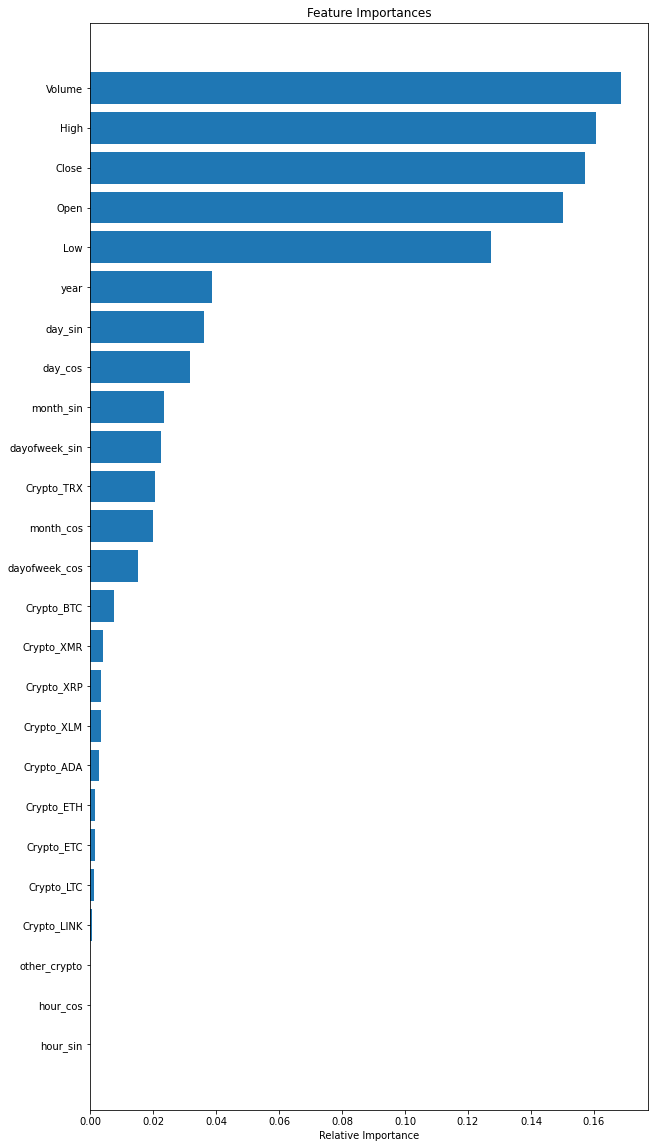

In [ ]:
features=norm_train_df.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [ ]:


data = pd.DataFrame(columns=['features', "rf_feature_imp"])
                    
data['features'] = norm_train_df.columns
data['rf_feature_imp'] = model.feature_importances_


# Light Gradient Boosting Model

Ref: https://lightgbm.readthedocs.io/en/v3.3.2/

In [ ]:
import lightgbm as lgb
unnorm_lgbm = lgb.LGBMClassifier(importance_type='gain')
unnorm_lgbm.fit(norm_train_df.fillna(0), target)

LGBMClassifier(importance_type='gain')

In [ ]:
lgbm_pred=unnorm_lgbm.predict(norm_test_df)

In [ ]:
generate_model_report(test_target, lgbm_pred, 'micro')
generate_model_report(test_target, lgbm_pred, 'macro')
generate_model_report(test_target, lgbm_pred, 'weighted')

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_target, lgbm_pred))

==================Printing the micro metrics===================
Accuracy =  0.4876816099099721
Precision =  0.4876816099099721
Recall =  0.4876816099099721
F1 Score =  0.4876816099099721
==================Printing the macro metrics===================
Accuracy =  0.4876816099099721
Precision =  0.47276355074097487
Recall =  0.3890493933966081
F1 Score =  0.3356998825239719
==================Printing the weighted metrics===================
Accuracy =  0.4876816099099721
Precision =  0.4774011462167295
Recall =  0.4876816099099721
F1 Score =  0.39276186225566

Classification Report

              precision    recall  f1-score   support

           0       0.48      0.93      0.64     39351
           1       0.55      0.19      0.29     25122
           2       0.38      0.05      0.08     22389

    accuracy                           0.49     86862
   macro avg       0.47      0.39      0.34     86862
weighted avg       0.48      0.49      0.39     86862



### Feature Importance

In [ ]:
feature_importances = (unnorm_lgbm.feature_importances_ / sum(unnorm_lgbm.feature_importances_)) 
temp_df = pd.DataFrame({'LGBM_feature_imp':feature_importances,'features':norm_train_df.columns}).sort_values(by="LGBM_feature_imp",ascending=False)
temp_df


,LGBM_feature_imp,features
1,0.319765,High
3,0.181994,Open
4,0.177674,Volume
0,0.090327,Close
5,0.086725,year
6,0.024949,month_sin
2,0.021518,Low
15,0.021501,Crypto_BTC
22,0.021111,Crypto_XMR
7,0.012460,month_cos


In [ ]:
data = data.merge(temp_df, on='features')

In [ ]:
data.sort_values(['rf_feature_imp', 'LGBM_feature_imp'], ascending=False)

,features,rf_feature_imp,LGBM_feature_imp
4,Volume,0.168710,0.177674
1,High,0.160595,0.319765
0,Close,0.157215,0.090327
3,Open,0.150096,0.181994
2,Low,0.127271,0.021518
5,year,0.038663,0.086725
8,day_sin,0.036068,0.007182
9,day_cos,0.031826,0.005139
6,month_sin,0.023515,0.024949
10,dayofweek_sin,0.022423,0.004264


### Saving the feature importance for the Future use

In [ ]:

temp_file_path = '/content/drive/MyDrive/MADS_23_DL_final_project/notebooks/chaitanya_temp_files'
data.to_csv(temp_file_path +"/random_forest_2h_3class_feature_3.csv", index=True)

#####Note:

 This Notebooks we have build models which are baseline for our future models where we will be adding additional useful features to the model.

# End of the Notebook